# <b>Insurance</b><a id='home'></a>

1. [Import Data and Packages](#import)
2. [Prepare Data](#prepare)
3. [Exploratory Data Analysis](#exploratory)
4. [Find Similar Customers (KNN)](#knn)
5. [Predict which Customers Recieve Benefits (Binary Classification)](#knn_class)
6. [Predict Number of Benefits (Multi Classification)](#knn_regress)
7. [Transform Data](#transform)
8. [Conclusion and Business Application](#conclusion)


## <b>Import Packages and Data</b><a id='import'></a>

In [34]:
# Import Packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

In [2]:
# User-defined GridSearchCV results function
def gscv_results(gscv_object, main_scorer, *add_scores):
    '''Take a GridSearchCV object and return best model parameters and a pandas
    dataframe of the main score and additional specified scorers for the best model.
    
    gscv_object: fitted GridSearchCV object with one or multiple scorers.
    main_scorer: scorer passed to gscv_object, or refit score if gscv_object has multiple scorers.
    add_scores: list of additional score names passed to gscv_object.'''
    cv_results = pd.DataFrame(gscv_object.cv_results_).sort_values(by=f'mean_test_{main_scorer}', ascending=False)

    best_params = gscv_object.best_params_
    best_index = gscv_object.best_index_

    # create data frame with best main score
    best_score = gscv_object.best_score_.round(4)
    results = pd.DataFrame(data={f'{main_scorer}':[best_score]})
    
    # for score in additional scores, add column with score
    for score in add_scores:
        results[f'{score}'] = cv_results.loc[best_index, f'mean_test_{score}'].round(4)

    return best_params, results

In [22]:
# User-defined cross_validate results function
def cv_results(cv_object, main_scorer, *add_scores):
    '''Take a cross_validate object and return pandas dataframe of the average 
    main score and average of any additional scores across cross validated 
    trials.
    
    cv_object: fitted cross_validate object with one or multiple scorers.
    main_scorer: scorer passed to cross_validate object, or refit score if cross_validate
    has multiple scorers.
    add_scores: list of additional score names passed to cv_object.'''
     # create data frame with best main score
    main_scorer_avg = cv_object[f'test_{main_scorer}'].mean()
    results = pd.DataFrame(data={f'{main_scorer}': [main_scorer_avg]})
    
    # for score in additional scores, calculate average and add column with score
    for score in add_scores:
        score_avg = cv_object[f'test_{score}'].mean()
        results[f'{score}'] = score_avg
    
    return results

In [4]:
# Read data
try:
    insure = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/insurance_us.csv')
except:
    insure = pd.read_csv('/datasets/insurance_us.csv')

In [5]:
# Print info
print(insure.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None


There are 5000 rows in the dataset and no missing values. All data types are correct.

In [6]:
# Print head
display(insure.head(10))

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


### Read data conclusions

This analysis has one dataset containing 5 columns and 5000 rows. Columns represent insurance clients' gender, age, salary, number of family members, and insurance benefits. Column names need to be changed to snake case. There are no missing values.

[back to top](#home)

## <b>Prepare Data</b><a id='prepare'></a>

Column names are changed to snake case, dataset is checked for duplicates, and a binary filed claim feature is added.

### Fix columns names

In [7]:
# Change columns to snake case
insure.columns = insure.columns.str.lower().str.replace(' ', '_')

print(insure.columns)

Index(['gender', 'age', 'salary', 'family_members', 'insurance_benefits'], dtype='object')


Columns are converted to snake case.

### Check for Duplicates

In [8]:
# Check for full duplicates
num_duplicates = insure.duplicated().sum()

print(f'The number of fully duplicated rows: {num_duplicates}')

The number of fully duplicated rows: 153


While there are duplicated rows, this is likely due to multiple people sharing the same gender, age, salary, family members, and insurance benefits. These duplicates will be left in the dataset.

### Add additional Features

In [44]:
# Add binary filed claim variable where
# 0 = filed no claims and 1 = filed at least one claime
insure['recieved_benefit'] = np.where(insure['insurance_benefits'] > 0, 1, 0)

display(insure.head())

,gender,age,salary,family_members,insurance_benefits,recieved_benefit
0,1,41.0,49600.0,1,0,0
1,0,46.0,38000.0,1,1,1
2,0,29.0,21000.0,0,0,0
3,0,21.0,41700.0,2,0,0
4,1,28.0,26100.0,0,0,0


### Prepare data conclusions

Variable names are snake case, duplicates have been explored, and a binary filed claim feature is added. The data is ready for analysis.

### <b>Exploratory Data Analysis</b><a id='exploratory'></a>

Variables' individual distributions are explored as well as pairwise plots for the full dataset and colored by number of insurance benefits. 

Pairs Plot:


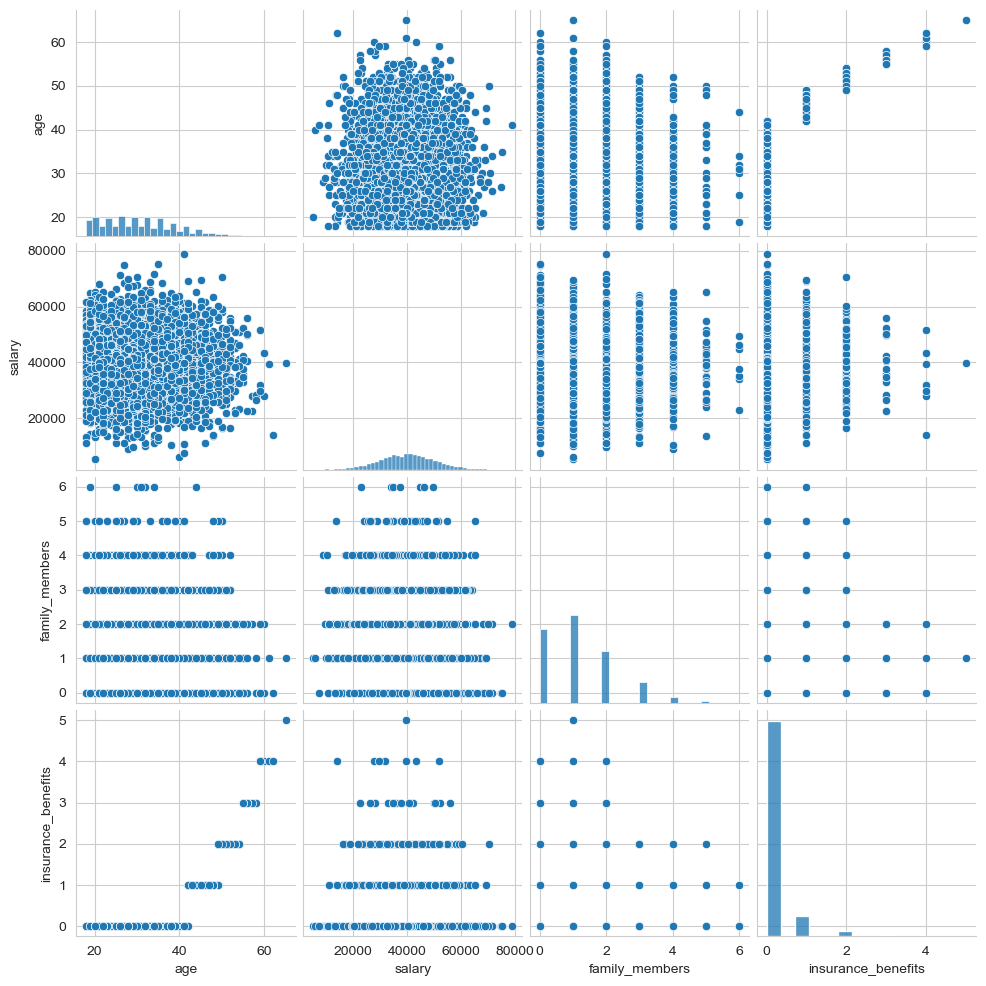

In [110]:
# Pair plot for age, salary, family members, and insurance benefits
sns.set_style('whitegrid')
sns.pairplot(insure.iloc[:, 1:5])

print('Pairs Plot:')
plt.show()

Age, family members, and insurance benefits are highly right skewed variables. Salary appears normally distributed. There is a non-linear relationship betweeen insurance benefits and age and family members. Assumptions of a linear regression appear violated, making this dataset a good candidate for non-parametric models.

Pairs Plot by Recieved Benefit:


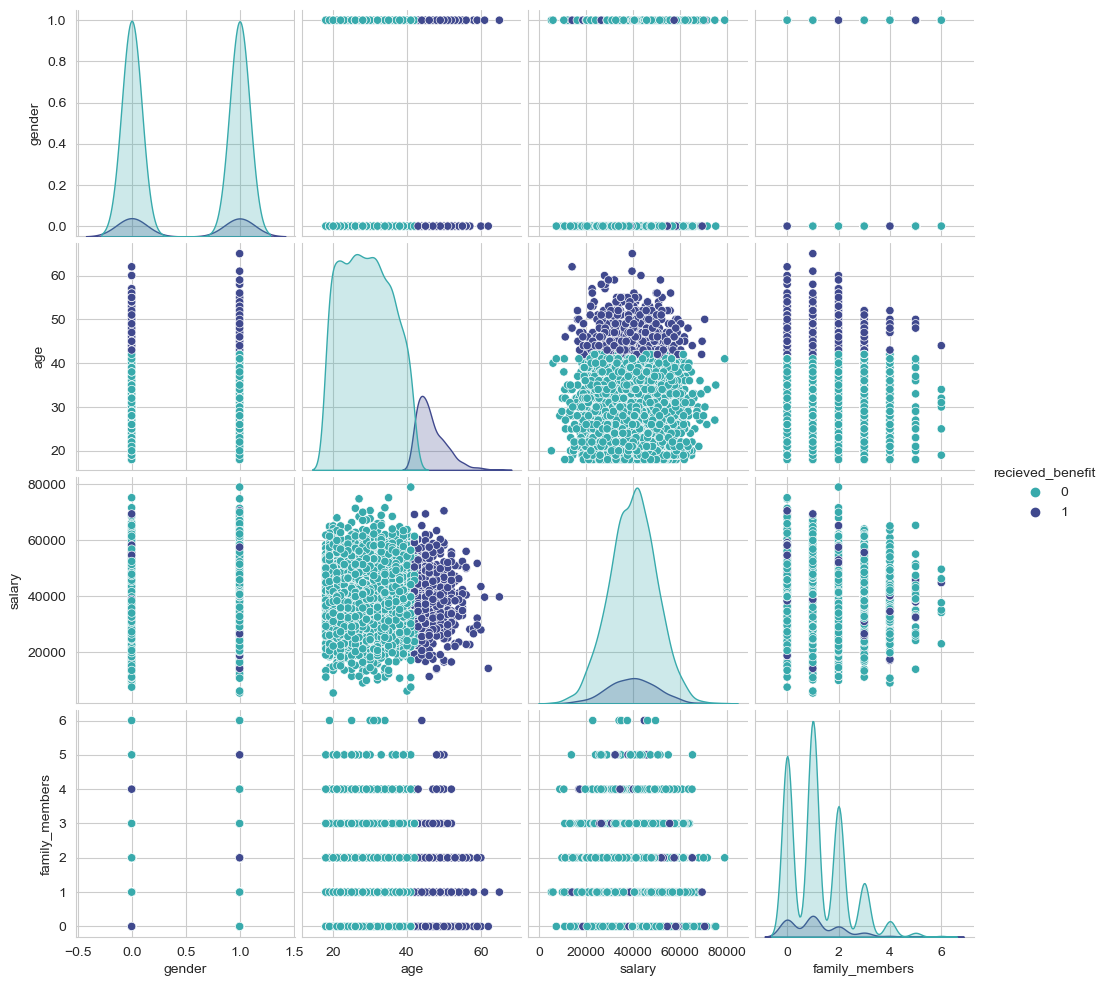

In [120]:
sns.set_style('whitegrid')
sns.pairplot(insure.iloc[:, [0, 1, 2, 3, 5]], hue='recieved_benefit', palette='mako_r')
sns.color_palette(palette='pastel')

print('Pairs Plot by Recieved Benefit:')
plt.show()

There is strong clustering in recieving benefits or not based on age. People between 18 and 40 have not recieved any benefits and those between 42 and 65 have all recieved benefits. There are no other strong associations or clustering between gender, salary, family members, and recieving insurance benefits.

Pairs Plot by Number of Benefits:


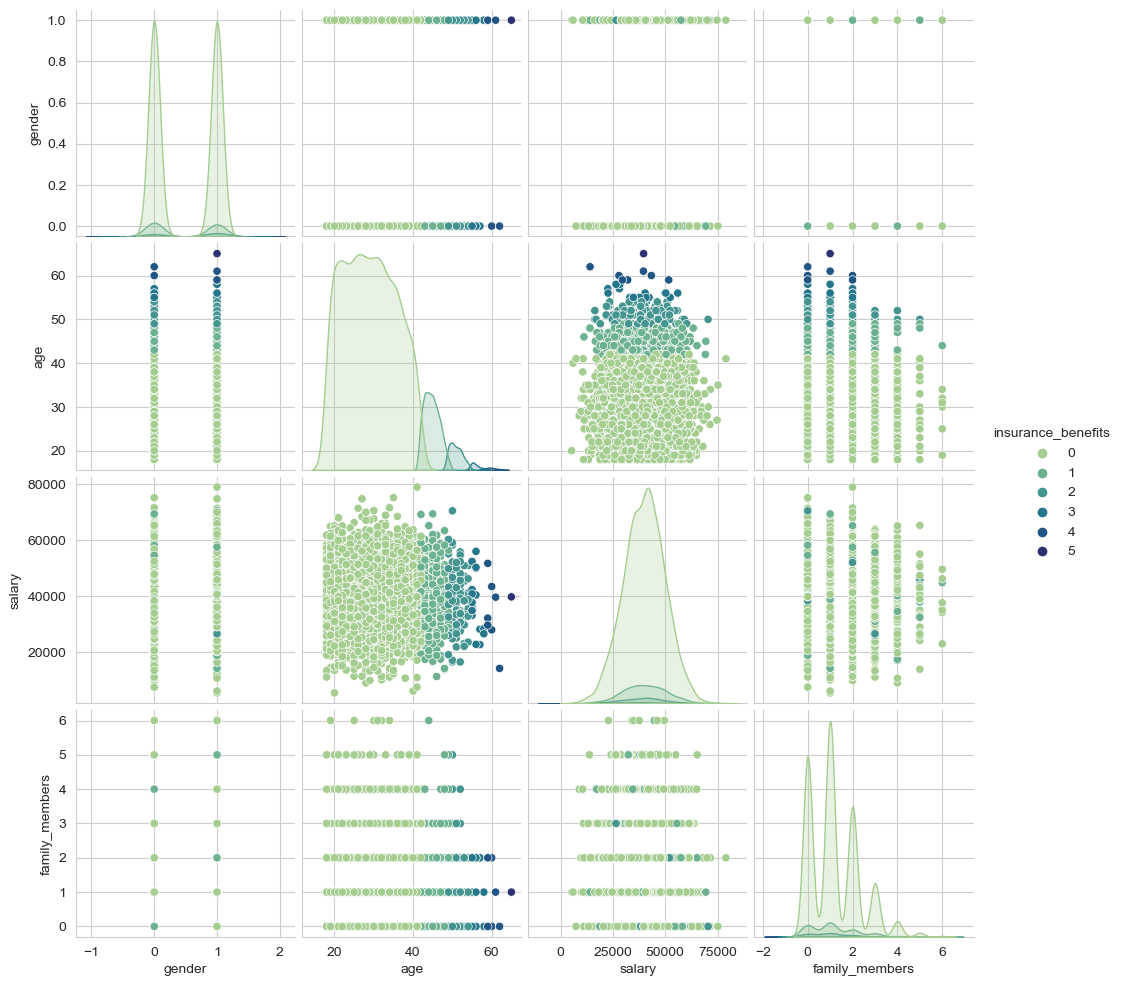

In [108]:
sns.set_style('whitegrid')
sns.pairplot(insure.iloc[:, 0:5], hue='insurance_benefits', palette='crest')

print('Pairs Plot by Number of Benefits:')
plt.show()

The number of benefits someone has recieved is again dependent on age. At older ages, people have all recieved a higher number of benefits. There are no other strong associations or clustering for number of benefits.

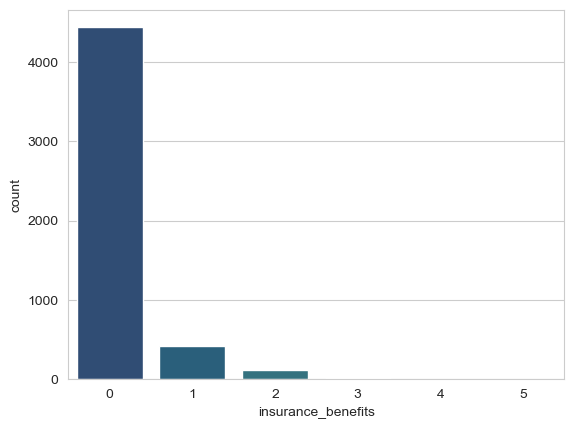

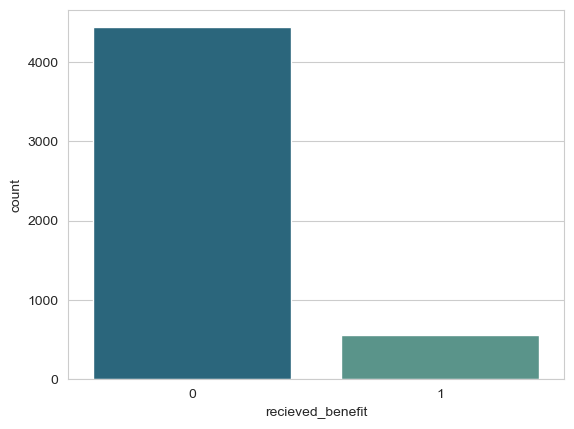

In [132]:
# Bar graphs of dependent variables
columns = ['insurance_benefits', 'recieved_benefit']

for column in columns:
    sns.countplot(x=insure[column], palette='crest_r')
    plt.show()

Far more people didn't recieve a benefit than did. There are very few people who recieved 2 or more benefits. There is an imbalance in classes.

In [12]:
# Frequency/Rel Freq/Cum Rel Feq table of gender, family members,
# total insurance benefits, and filed claim
columns = ['gender', 'family_members', 'insurance_benefits', 'recieved_benefit']

for column in columns:
    freq_table = insure[column].value_counts().sort_index().reset_index()

    freq_table['Relative Frequency'] = (insure[column]
                                             .value_counts(normalize=True)
                                             .sort_index()
                                             .values)

    freq_table['Cumulative Frequency'] = (insure[column]
                                               .value_counts(normalize=True)
                                               .sort_index()
                                               .cumsum().values)

    freq_table = freq_table.rename(columns={'index':'Claims Number',
                                            column:'Frequency'})
                                   
    print(f'Frequency Table {column}:')
    display(freq_table)


Frequency Table gender:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,2505,0.501,0.501
1,1,2495,0.499,1.000


Frequency Table family_members:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,1513,0.3026,0.3026
1,1,1814,0.3628,0.6654
2,2,1071,0.2142,0.8796
3,3,439,0.0878,0.9674
4,4,124,0.0248,0.9922
5,5,32,0.0064,0.9986
6,6,7,0.0014,1.0000


Frequency Table insurance_benefits:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,423,0.0846,0.9718
2,2,115,0.0230,0.9948
3,3,18,0.0036,0.9984
4,4,7,0.0014,0.9998
5,5,1,0.0002,1.0000


Frequency Table recieved_benefit:


,Claims Number,Frequency,Relative Frequency,Cumulative Frequency
0,0,4436,0.8872,0.8872
1,1,564,0.1128,1.0000


There are almost equal numbers of men and women in the dataset. Of customers in this dataset, the most common number of family members is one with 36.38% having one family member, followed by 30.26% having no family members. Only 3.26% of customers have 4 or more family members.  88.72% recieved no insurance benefits, while only 8.46% recieved one benefit, and 2.82% recieved two or more benefits. Similarly, 88.72% of customers recieved no benefit vs 11.28% recieved at least one benefit. This is an imbalanced classification problem.

### Exploratory Data Analysis Conclusion

Some of the categories in family members and insurance benefits have very few observations. The large violations in parametric assumptions make this dataset a good candidate for non-parametric models. The analysis will proceed with K Nearest Neighbors.

[back to top](#home)

## <b>Find Similar Customers</b><a id='knn'></a>

Use K Nearest Neighbors to find customers similar to a given customer.

In [13]:
# Initiate Nearest Neighbors Class to find closest 5 customers
knn = NearestNeighbors(n_neighbors=5).fit(insure)

# Test model on my characteristics
print(knn.kneighbors([[0, 29, 60000, 1, 0, 0]]))

(array([[  7.14142843, 100.0099995 , 100.01499888, 100.01499888,
        100.019998  ]]), array([[3520, 1555, 1742, 1418, 2239]]))


/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


## <b>Predict which Customers Recieve Benefits</b><a id='knn_class'></a>

<b>Purpose:</b> Machine learning classification models are tuned and cross-validated to find the model that best predicts which customers recieve insurance benefits. This is an imbalanced binary classification problem.

<b>Techniques:</b> Pipelines, GridSearchCV, and imbalanced classification techniques are utilized to fit and tune k-nearest neighbor classifier and logistic regression models with the purpose of maximizing F1 score. Imbalanced classes are balanced using SMOTE, SMOTEENN, and weighting, and the logistic regression threshold is tuned.   

<b>Sections:</b>  
[KNN Models](#knn_class)  
[Logistic Regression Models](#log_reg)  
[Training Results](#results_class)  
[Test Results](#test_class)  
[Classification Conclusions](#conclusion_class)

### Prepare training and test sets

In [14]:
# Define features and target
features = insure.drop(['insurance_benefits', 'recieved_benefit'], axis=1)
target_class = insure['recieved_benefit']

print('Features:')
display(features.head())
print()

print('Target:')
display(target_class.head().to_frame())

Features:


,gender,age,salary,family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0



Target:


,recieved_benefit
0,0
1,1
2,0
3,0
4,0


In [15]:
# Split data into train and test
features_train, features_test, target_train_class, target_test_class = train_test_split(features, target_class,
                                                                            test_size=0.25, random_state=123)

print(f'Features Train: {features_train.shape}')
print(f'Target Train: {target_train_class.shape}')

print(f'Features Test: {features_test.shape}')
print(f'Target Test: {target_test_class.shape}')

Features Train: (3750, 4)
Target Train: (3750,)
Features Test: (1250, 4)
Target Test: (1250,)


### Fit and tune knn models<a id='knn_class'></a>

In [16]:
# Pipeline to scale and tune k neighbors classifier with 
# imbalanced classes

# define scaler for numeric columns
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), slice(1, 4))],
    remainder='passthrough'
)

# pipeline to scale and fit knn
pipe = Pipeline(steps=[('scale', preprocessor), ('knn', KNeighborsClassifier())])

grid = {
    'knn__n_neighbors':np.arange(1, 25, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'knn__algorithm':['ball_tree','kd_tree', 'brute']
}

# define multiple scores for GridSearchCV
scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

# scale, tune, and fit knn 
knn_class_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, cv=3, refit='f1')
knn_class_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                         'knn__weights': ['uniform', 'distance']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [385]:
# User-defined function to extract training results
imb_knn_best_params, imbalanced_knn_results = gscv_results(knn_class_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('Imbalanced KNN Best Parameters:')
print(imb_knn_best_params)
print()

print('Imbalanced KNN CV Results:')
display(imbalanced_knn_results)

Imbalanced KNN Best Parameters:
{'knn__algorithm': 'kd_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}

Imbalanced KNN CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9279,0.9468,0.9843,0.9595,0.8983


In [17]:
# Pipeline to upsample with SMOTE, scale features, and tune KNN classifier
upsample = SMOTE(random_state=123)

pipe_smote = Pipeline([('smt', upsample), ('scale', preprocessor), ('knn', KNeighborsClassifier())])

grid = {
    'knn__n_neighbors': np.arange(1, 26, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'knn__algorithm':['ball_tree','kd_tree', 'brute'],
    'smt__k_neighbors': np.arange(1, 22, 2)
}

scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

knn_class_smt_gscv = GridSearchCV(pipe_smote, param_grid=grid, scoring=scores, cv=3, refit='f1')
knn_class_smt_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25]),
                         'knn__weights': ['uniform', 'distance'],
                         'smt__k_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21])},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [384]:
# User-defined function to extract training results
smote_knn_best, smote_knn_results = gscv_results(knn_class_smt_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTE KNN Best Parameters:')
print(smote_knn_best)
print()
print('SMOTE KNN CV Results:')
display(smote_knn_results)

SMOTE KNN Best Parameters:
{'knn__algorithm': 'ball_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'smt__k_neighbors': 11}

SMOTE KNN CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9409,0.998,0.9861,0.9059,0.9787


In [18]:
# Pipeline to up and down sample with SMOTEENN, scale, and tune KNN classifier
upsample_smtn = SMOTEENN(random_state=123)

pipe_smtn = Pipeline([('smtn', upsample_smtn), ('scale', preprocessor), ('knn', KNeighborsClassifier())])

grid = {
    'knn__n_neighbors': np.arange(1, 21, 2),
    'knn__weights':['uniform', 'distance'],
    'knn__metric':['euclidean', 'cityblock', 'minkowski'],
    'knn__algorithm':['ball_tree','kd_tree', 'brute'],
    'smtn__smote': [SMOTE(k_neighbors=1), 
                    SMOTE(k_neighbors=5), 
                    SMOTE(k_neighbors=10)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=3),
                  EditedNearestNeighbours(n_neighbors=5)]
}

# define scores for GridSearchCV
scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

knn_class_smtn_gscv = GridSearchCV(pipe_smtn, param_grid=grid, scoring=scores, cv=3, refit='f1')
knn_class_smtn_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smtn', SMOTEENN(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'cityblock', 'minkowski'],
                         'knn__n_neig...15, 17, 19]),
                         'knn__weights': ['uniform', 'distance'],
                         'smtn__enn': [EditedNearestNeighbours(n_neighbors=1),
                                       EditedNearestNeighbours(),
                                       EditedNearestNeighbours(n_neighbors=5)],
                         'smtn__smote': [SMOTE(k_neighbors=1), SMOTE(),
                                         SMOTE(k_neighbors=10)]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [383]:
smtn_knn_best, smtn_knn_results = gscv_results(knn_class_smtn_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTEENN KNN Best Parameters:')
print(smtn_knn_best)
print()
print('SMOTEENN KNN CV Results:')
display(smtn_knn_results)

SMOTEENN KNN Best Parameters:
{'knn__algorithm': 'kd_tree', 'knn__metric': 'cityblock', 'knn__n_neighbors': 1, 'knn__weights': 'distance', 'smtn__enn': EditedNearestNeighbours(n_neighbors=1), 'smtn__smote': SMOTE()}

SMOTEENN KNN CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9365,0.9611,0.9859,0.9444,0.9291


### Fit and tune logistic regression<a id='log_reg'></a>

In [24]:
# Pipeline to scale, fit, and cross validate logistic regression with 
# imbalanced classes
model = LogisticRegression(solver='liblinear')

pipe = Pipeline([('scale', preprocessor), ('model', model)])

scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

logreg_cv = cross_validate(pipe, features_train, target_train_class,
                               scoring=scores, cv=3)

In [25]:
logreg_results = cv_results(logreg_cv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('Imbalanced Logistic Regression CV Results:')
display(logreg_results.round(4))

Imbalanced Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9745,0.9999,0.9944,1.0,0.9504


In [26]:
# Pipeline to scale, fit, and cross validate logistic regression with 
# class weighting
model = LogisticRegression(solver='liblinear', class_weight='balanced')

pipe = Pipeline([('scale', preprocessor), ('model', model)])

scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

logreg_wtd_cv = cross_validate(pipe, features_train, target_train_class,
                               scoring=scores, cv=3)

In [27]:
logreg_wtd_results = cv_results(logreg_wtd_cv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('Weighted Classes Logistic Regression CV Results:')
display(logreg_wtd_results)

Weighted Classes Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.869927,0.999981,0.966133,0.770337,1.0


In [292]:
# Pipeline to scale, fit, and cross validate unweighted logistic regression 
# with SMOTE
model = LogisticRegression(solver='liblinear')
upsample = SMOTE(random_state=123)

pipe = Pipeline([('smt', upsample), ('scale', preprocessor), ('model', model)])

grid = {
    'smt__k_neighbors': np.arange(1, 26, 1)
}

scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

logreg_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, 
                                   cv=3, refit='f1')
logreg_smt_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'smt__k_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [380]:
logreg_smt_best, logreg_smt_results = gscv_results(logreg_smt_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTE Logistic Regression Best Parameters:')
print(logreg_smt_best)
print()
print('SMOTE Logistic Regression CV Results:')
display(logreg_smt_results)

SMOTE Logistic Regression Best Parameters:
{'smt__k_neighbors': 19}

SMOTE Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9248,0.9997,0.9816,0.8605,1.0


In [290]:
# Pipeline to scale, fit, and cross validate unweighted logistic regression 
# with SMOTEENN
model = LogisticRegression(solver='liblinear')
upsample = SMOTEENN(random_state=123)

pipe = Pipeline([('smtn', upsample), ('scale', preprocessor), ('model', model)])

grid = {
    'smtn__smote': [SMOTE(k_neighbors=1), 
                    SMOTE(k_neighbors=5), 
                    SMOTE(k_neighbors=10),
                    SMOTE(k_neighbors=15),
                    SMOTE(k_neighbors=20)],
    'smtn__enn': [EditedNearestNeighbours(n_neighbors=1), 
                  EditedNearestNeighbours(n_neighbors=3),
                  EditedNearestNeighbours(n_neighbors=5),
                  EditedNearestNeighbours(n_neighbors=10)]
}

scores = {'accuracy': 'accuracy', 'precision': 'precision', 
          'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

logreg_smtn_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scores, 
                                   cv=3, refit='f1')
logreg_smtn_gscv.fit(features_train, target_train_class)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smtn', SMOTEENN(random_state=123)),
                                       ('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         slice(1, 4, None))])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'smtn__enn': [EditedNearestNeighbours(n_neighbors=1),
                                       EditedNearestNeighbours(),
                                       EditedNearestNeighbours(n_neighbors=5),
                                       EditedNearestNeighbours(n_neighbors=10)],
                         'smtn__smote': [SMOTE(k_neighbors=1), SMOTE(),
                                         SMOTE(k_neighbors=10),
                                         SMOTE(k_neighbors=15),
                                         SMOTE(k_neighbors=20)]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [379]:
logreg_smtn_best, logreg_smtn_results = gscv_results(logreg_smtn_gscv, 'f1', 'roc_auc', 'accuracy', 'precision', 'recall')

print('SMOTEENN Logistic Regression Best Parameters:')
print(logreg_smtn_best)
print()
print('SMOTEEN Logistic Regression CV Results:')
display(logreg_smtn_results)

SMOTEENN Logistic Regression Best Parameters:
{'smtn__enn': EditedNearestNeighbours(), 'smtn__smote': SMOTE(k_neighbors=20)}

SMOTEEN Logistic Regression CV Results:


,f1,roc_auc,accuracy,precision,recall
0,0.9571,0.9995,0.9899,0.92,0.9976


In [28]:
# Logistic regression threshold optimatiation

# split training set into train and validate for optimization
features_train_opt, features_valid_opt, target_train_opt, target_valid_opt = train_test_split(
    features_train, target_train_class, test_size=0.25, random_state=123)

# scale and fit model
logreg = LogisticRegression(random_state=123)

pipe_logreg = Pipeline([('scale', preprocessor), ('model', logreg)])

pipe_logreg.fit(features_train_opt, target_train_opt)

# extract predicted probabilities
pred_prob = pipe_logreg.predict_proba(features_valid_opt)
pred_prob = pred_prob[:, 1]

# Threshold tuning to maximize f1 score
thresholds = np.arange(0, 1.1, 0.01)
f1_scores = np.zeros(len(thresholds))

for index, elem in enumerate(thresholds):
    predictions = np.where(pred_prob > elem, 1, 0)
    f1_scores[index] = f1_score(target_valid_opt, predictions)
    
index = np.argmax(f1_scores)
threshold_opt = thresholds[index]
f1_score_opt = f1_scores[index]

print(f'Optimal Threshold: {threshold_opt}')
print(f'Optimal F1 Score: {f1_score_opt}')

Optimal Threshold: 0.43
Optimal F1 Score: 1.0


In [20]:
# Score model based on optimal threshold
preds_opt = np.where(pred_prob > threshold_opt, 1, 0)

logreg_thres_results = pd.DataFrame(data={'f1':[f1_score(target_valid_opt, preds_opt)],
                                          'roc_auc':[roc_auc_score(target_valid_opt, preds_opt)],
                                          'accuracy':[accuracy_score(target_valid_opt, preds_opt)],
                                          'precision':[precision_score(target_valid_opt, preds_opt)],
                                          'recall':[recall_score(target_valid_opt, preds_opt)]})

print('Optimized Threshold Logistic Regression Results:')
display(logreg_thres_results)

Optimized Threshold Logistic Regression Results:


,f1,roc_auc,accuracy,precision,recall
0,1.0,1.0,1.0,1.0,1.0


### Classification Training Results<a id='results_class'></a>

In [389]:
# Display results of classifier analysis
results_full = pd.concat([imbalanced_knn_results, smote_knn_results,
                smtn_knn_results, logreg_results, logreg_wtd_results, 
                logreg_smt_results, logreg_smtn_results, logreg_thres_results])

results_full.index = ['Imbalanced KNN', 'SMOTE KNN',
                   'SMOTEENN KNN', 'Imbalanced Log Reg',
                   'Weighted Log Reg', 'SMOTE Log Reg',
                   'SMOTEENN Log Reg', 'Threshold Opt Log Reg']

print('Results of Machine Learning Classifier Analysis:')
display(results_full.sort_values(by='f1', ascending=False).round(4))

Results of Machine Learning Classifier Analysis:


,f1,roc_auc,accuracy,precision,recall
Threshold Opt Log Reg,1.0000,1.0000,1.0000,1.0000,1.0000
Imbalanced Log Reg,0.9745,0.9999,0.9944,1.0000,0.9504
SMOTEENN Log Reg,0.9571,0.9995,0.9899,0.9200,0.9976
SMOTE KNN,0.9409,0.9980,0.9861,0.9059,0.9787
SMOTEENN KNN,0.9365,0.9611,0.9859,0.9444,0.9291
Imbalanced KNN,0.9279,0.9468,0.9843,0.9595,0.8983
SMOTE Log Reg,0.9248,0.9997,0.9816,0.8605,1.0000
Weighted Log Reg,0.8699,1.0000,0.9661,0.7703,1.0000


Threshold optimized logisitic regression was the highest scoring model, achieving an F1, ROC AUC, accuracy, precision, and recall score of 1.0. This is followed by the imbalanced logistic regression and logistic regression with SMOTEENN class balancing. All of the KNN models did similarly, with F1 scores all between 0.93 and 0.94. Weighted logistic regression, while achieving perfect recall, had the lowest precision and F1 scores.

### Classification test results <a id='class_test'></a>

In [33]:
# Test logistic regression with threshold = 0.43 on test set
threshold_opt = 0.43

pred_proba_test = pipe_logreg.predict_proba(features_test)[:, 1]

pred_test = np.where(pred_proba_test > threshold_opt, 1, 0)

logreg_test_results = pd.DataFrame(data={'f1':[f1_score(target_test_class, pred_test)],
                                          'roc_auc':[roc_auc_score(target_test_class, pred_test)],
                                          'accuracy':[accuracy_score(target_test_class, pred_test)],
                                          'precision':[precision_score(target_test_class, pred_test)],
                                          'recall':[recall_score(target_test_class, pred_test)]})

print('Logistic Regression Threshold = 0.43 Test:')
display(logreg_test_results)

Logistic Regression Threshold = 0.43 Test:


,f1,roc_auc,accuracy,precision,recall
0,1.0,1.0,1.0,1.0,1.0


The logistic regression with threshold = 0.43 that was scaled and fit on the training set was able to achieve an f1, roc_auc, accuracy, precision, and recall score of 1.0 on the test set. This is the same score as on the training set and represents a model that can make perfect predictions both on training data and on new data it has not seen.

### Classification Conclusions<a id='conclusion_class'></a>

K nearest neighbors and logistic regression models were fit and tuned with class balancing techniques. The best classifier was the logistic regression with a threshold of 0.43. This model was able to achieve scores of 1.0 across the board for F1, roc_auc, accuracy, precision, and recall on the training set and was able to repeat those scores again on the test set. This model predicts both those that did and those that did not use insurance benefits with 100% accuracy. It is a perfect predictor.

[back to top](#home)

## <b>Predict Number of Benefits</b><a id='knn_regress'></a>

### Prepare training and test sets 

In [127]:
# Specify new target
target_mult = insure['insurance_benefits']

print('Features:')
display(features.head())
print()
print('Target:')
display(target_mult.head().to_frame())

Features:


,gender,age,salary,family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0



Target:


,insurance_benefits
0,0
1,1
2,0
3,0
4,0


In [133]:
# Split data into training and test
feat_train_mult, feat_test_mult, targ_train_mult, targ_test_mult = train_test_split(
    features, target_mult, test_size=0.25, random_state=123)

print(f'Features Train: {features_train.shape}')
print(f'Target Train: {target_train_class.shape}')

print(f'Features Test: {features_test.shape}')
print(f'Target Test: {target_test_class.shape}')

Features Train: (3750, 4)
Target Train: (3750,)
Features Test: (1250, 4)
Target Test: (1250,)


## <b>Transformation<b><a id='transform'></a>

## <b>Conclusion and Business Application</b><a id='conclusion'></a>